In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [4]:
from Preprocessor import Preprocessor
from Registerer import Registerer
import SimpleITK as sitk
import ndreg

### Step 1: Load data

In [5]:
img = ndreg.imgRead('../forVikram/ailey-dev_thy1eyfp_control_9_upload20170919_ch1_res3.img')
atlas = ndreg.imgRead('../forVikram/ara3_average_res2.img')

### Step 2: initialize Preprocessor class

In [6]:
preprocessor = Preprocessor(img)

### Step 3: remove streaks

In [11]:
new_img = preprocessor.remove_streaks()

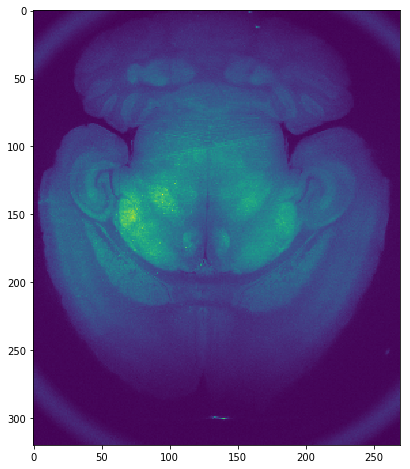

In [12]:
plt.imshow(preprocessor.img_np[80,:,:])
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


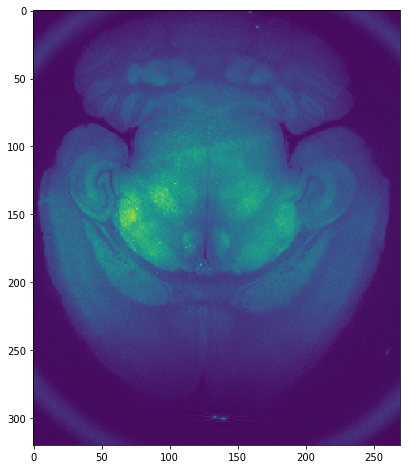

In [8]:
plt.imshow(new_img[80,:,:].astype('float'))
plt.show()

### Step 4: Remove circle

In [9]:
img_no_circle = preprocessor.remove_circle()

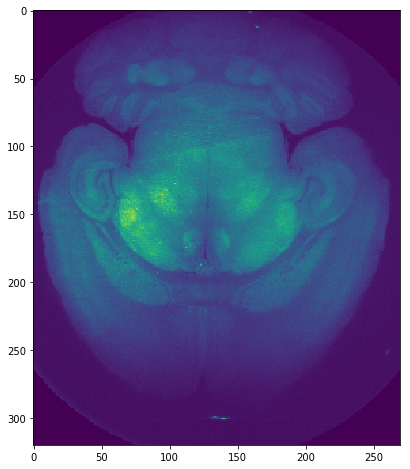

In [10]:
plt.imshow(img_no_circle[80,:,:])
plt.show()

### Step 5: create mask

In [15]:
mask = preprocessor.create_mask()

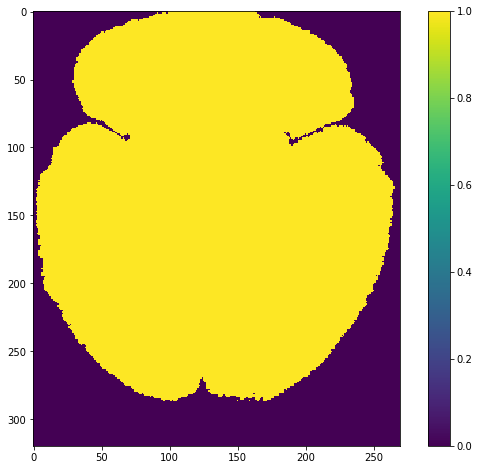

In [16]:
plt.imshow(mask[80,:,:])
plt.colorbar()
plt.show()

### Step 5: Correct Bias field

In [17]:
img_bias_corrected = preprocessor.correct_bias_field(scale=0.1)

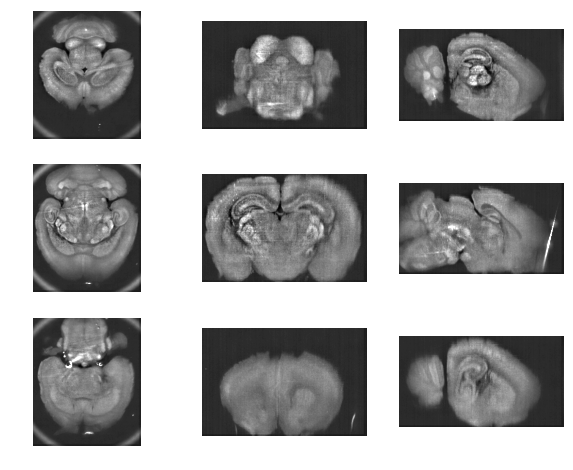

In [18]:
ndreg.imgShow(img_bias_corrected, vmax=1000)

## Registration

In [8]:
registerer = Registerer(img, atlas)

### Perform affine registration

In [9]:
atlas_affine = registerer.register_affine("RPS", "LSA", [0.100, 0.100, 0.100], iterations=100.0, resolutions=4.0)

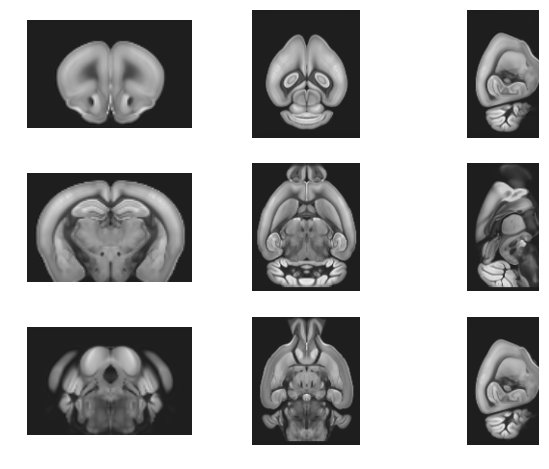

In [10]:
ndreg.imgShow(atlas_affine)

### Perform LDDMM registration

In [ ]:
atlas_lddmm = registerer.register_lddmm(atlas_affine, registerer.img, scaleList=[0.01])


Step 0: alpha=0.05, beta=0.05, scale=0.01
